### From Factorization to Period Finding

The number theory that underlines Shor's algorithm relates to periodic modulo sequences. Let's have a look at an example of such a sequence. Consider the sequence of the powers of two: 
$$1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, ...$$
Now let's look at the same sequence 'modulo 15', that is, the remainder after fifteen divides each of these powers of two:
$$1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, ...$$
This is a modulo sequence that repeats every four numbers, that is, a periodic modulo sequence with a period of four.

Reduction of factorization of $N$ to the problem of finding the period of an integer $x$ less than $N$ and greater than $1$ depends on the following result from number theory:

> The function $\mathcal{F}(a) = x^a \bmod N$ is a periodic function, where $x$ is an integer coprime to $N$ and $a \ge 0$.

Note that two numbers are coprime, if the only positive integer that divides both of them is 1. This is equivalent to their greatest common divisor being 1. For example, 8 and 15 are coprime, as they don't share any common factors (other than 1). However, 9 and 15 are not coprime, since they are both divisible by 3 (and 1). 

> Since $\mathcal{F}(a)$ is a periodic function, it has some period $r$. Knowing that $x^0 \bmod N = 1$, this means that $x^r \bmod N = 1$ since the function is periodic, and thus $r$ is just the first nonzero power where $x^r = 1 (\bmod N)$.

Given this information and through the following algebraic manipulation: 
$$ x^r \equiv 1 \bmod N $$
$$ x^r = (x^{r/2})^2 \equiv 1 \bmod N $$
$$ (x^{r/2})^2 - 1 \equiv 0 \bmod N $$
and if $r$ is an even number:
$$ (x^{r/2} + 1)(x^{r/2} - 1) \equiv 0 \bmod N $$

From this, the product $(x^{r/2} + 1)(x^{r/2} - 1)$ is an integer multiple of $N$, the number to be factored. Thus, so long as $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is not a multiple of $N$, then at least one of $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ must have a nontrivial factor in common with $N$. 

So computing $\text{gcd}(x^{r/2} - 1, N)$ and $\text{gcd}(x^{r/2} + 1, N)$ will obtain a factor of $N$, where $\text{gcd}$ is the greatest common denominator function, which can be calculated by the polynomial time [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm). 

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import math
import random

In [1]:
def find_period_classical(x, N):
    n = 1
    t = x
    while t != 1:
        t *= x
        t %= N
        n += 1
    return n

In [2]:
N = 15

def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q

x,r,p,q = shors_algorithm_classical(N)
print("semiprime N = ",N,", coprime x = ",x,", period r = ",r,", prime factors = ",p," and ",q,sep="")

semiprime N = 15, coprime x = 5, period r = 0, prime factors = 5 and 3.0


### Quantum Period Finding <a id='quantumperiodfinding'></a>

Let's first describe the quantum period finding algorithm, and then go through a few of the steps in detail, before going through an example. This algorithm takes two coprime integers, $x$ and $N$, and outputs $r$, the period of $\mathcal{F}(a) = x^a\bmod N$.

<ol>
<li> 

Choose $T = 2^t$ such that $N^2 \leq T \le 2N^2$. Initialise two registers of qubits, first an argument register with $t$ qubits and second a function register with $n = log_2 N$ qubits. These registers start in the initial state:

$$\vert\psi_0\rangle = \vert 0 \rangle \vert 0 \rangle$$ 

</li>
<li> 

Apply a Hadamard gate on each of the qubits in the argument register to yield an equally weighted superposition of all integers from $0$ to $T$:


$$\vert\psi_1\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert 0 \rangle$$ 

</li>
<li> 

Implement the modular exponentiation function $x^a \bmod N$ on the function register, giving the state:
$$\vert\psi_2\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert x^a \bmod N \rangle$$
This $\vert\psi_2\rangle$ is highly entangled and exhibits quantum parallism, i.e. the function entangled in parallel all the 0 to $T$ input values with the corresponding values of $x^a \bmod N$, even though the function was only executed once. </li>
<li> 

Perform a quantum Fourier transform on the argument register, resulting in the state:


$$\vert\psi_3\rangle = \frac{1}{T}\sum_{a=0}^{T-1}\sum_{z=0}^{T-1}e^{(2\pi i)(az/T)}\vert z \rangle \vert x^a \bmod N \rangle$$

where due to the interference, only the terms $\vert z \rangle$ with


$$z = qT/r $$

have significant amplitude where $q$ is a random integer ranging from $0$ to $r-1$ and $r$ is the period of $\mathcal{F}(a) = x^a\bmod N$. </li>
<li> 

Measure the argument register to obtain classical result $z$. With reasonable probability, the continued fraction approximation of $T / z$ will be an integer multiple of the period $r$. Euclid's algorithm can then be used to find $r$.</li>
</ol>

Note how quantum parallelism and constructive interference have been used to detect and measure periodicity of the modular exponentiation function.  The fact that interference makes it easier to measure periodicity should not come as a big surprise. After all, physicists routinely use scattering of electromagnetic waves and interference measurements to determine periodicity of physical objects such as crystal lattices. Likewise, Shor's algorithm exploits interference to measure periodicity of arithmetic objects, a computational interferometer of sorts. 

####  Modular Exponentiation

The modular exponentiation, step 3 above, that is the evaluation of $x^a \bmod N$ for $2^t$ values of $a$ in parallel, is the most demanding part of the algorithm. This can be performed using the following identity for the binary representation of any integer: $x = x_{t-1}2^{t-1} + ... x_12^1+x_02^0$, where $x_t$ are the binary digits of $x$. From this, it follows that:

\begin{aligned}
x^a \bmod N & = x^{2^{(t-1)}a_{t-1}} ... x^{2a_1}x^{a_0} \bmod N \\
& = x^{2^{(t-1)}a_{t-1}} ... [x^{2a_1}[x^{2a_0} \bmod N] \bmod N] ... \bmod N \\
\end{aligned}

This means that 1 is first multiplied by $x^1 \bmod N$ if and only if $a_0 = 1$, then the result is multiplied by $x^2 \bmod N$ if and only if $a_1 = 1$ and so forth, until finally the result is multiplied by $x^{2^{(s-1)}}\bmod N$ if and only if $a_{t-1} = 1$. 

Therefore, the modular exponentiation consists of $t$ serial multiplications modulo $N$, each of them controlled by the qubit $a_t$. The values $x,x^2,...,x^{2^{(t-1)}} \bmod N$ can be found efficiently on a classical computer by repeated squaring.

#### Quantum Fourier Transform

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT), step 4 above, is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. 

The classical discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:
$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

#### Example

Let's factorize $N = 21$ with coprime $x=2$, following the [above steps](#stepstwo) of the quantum period finding algorithm, which should return $r = 6$. This example follows one from [this](https://arxiv.org/abs/quant-ph/0303175) tutorial. 

1. Choose $T = 2^t$ such that $N^2 \leq T \le 2N^2$. For $N = 21$, the smallest value of $t$ is 9, meaning $T = 2^t = 512$. Initialise two registers of qubits, first an argument register with $t = 9$ qubits, and second a function register with $n = log_2 N = 5$ qubits: 
$$\vert\psi_0\rangle = \vert 0 \rangle \vert 0 \rangle$$

2. Apply a Hadamard gate on each of the qubits in the argument register: 
$$\vert\psi_1\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert 0 \rangle = \frac{1}{\sqrt{512}}\sum_{a=0}^{511}\vert a \rangle \vert 0 \rangle$$

3. Implement the modular exponentiation function $x^a \bmod N$ on the function register:

$$
\begin{align*}
\vert\psi_2\rangle 
&= \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert x^a \bmod N \rangle \\
&= \frac{1}{\sqrt{512}}\sum_{a=0}^{511}\vert a \rangle \vert 2^a \bmod 21 \rangle \\
&= \frac{1}{\sqrt{512}} \bigg( \vert 0 \rangle \vert 1 \rangle + \vert 1 \rangle \vert 2 \rangle +
\vert 2 \rangle \vert 4 \rangle + \vert 3 \rangle \vert 8 \rangle + \vert 4 \rangle \vert 16 \rangle + \vert 5 \rangle \vert 11 \rangle + \\
&\quad \vert 6 \rangle \vert 1 \rangle + \vert 7 \rangle \vert 2 \rangle + \vert 8 \rangle \vert 4 \rangle + \vert 9 \rangle \vert 8 \rangle + \vert 10 \rangle \vert 16 \rangle + \vert 11 \rangle \vert 11 \rangle + \\
&\quad \vert 12 \rangle \vert 1 \rangle + \ldots \bigg)
\end{align*}
$$

Notice that the above expression has the following pattern: the states of the second register of each “column” are the same. Therefore, we can rearrange the terms in order to collect the second register:

$$
\begin{align*}
\vert\psi_2\rangle 
&= \frac{1}{\sqrt{512}} \bigg[ \big(\vert 0 \rangle + \vert 6 \rangle + \vert 12 \rangle + \ldots + \vert 504 \rangle + \vert 510 \rangle\big) \vert 1 \rangle + \\
&\quad \big(\vert 1 \rangle + \vert 7 \rangle + \vert 13 \rangle + \ldots + \vert 505 \rangle + \vert 511 \rangle\big) \vert 2 \rangle + \\
&\quad \big(\vert 2 \rangle + \vert 8 \rangle + \vert 14 \rangle + \ldots + \vert 506 \rangle\big) \vert 4 \rangle + \\
&\quad \big(\vert 3 \rangle + \vert 9 \rangle + \vert 15 \rangle + \ldots + \vert 507 \rangle\big) \vert 8 \rangle + \\
&\quad \big(\vert 4 \rangle + \vert 10 \rangle + \vert 16 \rangle + \ldots + \vert 508 \rangle\big) \vert 16 \rangle + \\
&\quad \big(\vert 5 \rangle + \vert 11 \rangle + \vert 17 \rangle + \ldots + \vert 509 \rangle\big) \vert 11 \rangle \bigg]
\end{align*}
$$


4. To simplify following equations, we'll measure the function register before performing a quantum Fourier transform on the argument register. This will yield one of the following numbers with equal probability: $\{1,2,4,6,8,16,11\}$. Suppose that the result of the measurement was $2$, then:

$$\vert\psi_3\rangle = \frac{1}{\sqrt{86}}(\vert 1 \rangle + \;\vert 7 \rangle + \vert 13 \rangle \ldots + \vert 505 \rangle + \vert 511 \rangle)\, \vert 2 \rangle $$

It does not matter what is the result of the measurement; what matters is the periodic pattern. The period of the states of the first register is the solution to the problem and the quantum Fourier transform can reveal the value of the period.

5. Perform a quantum Fourier transform on the argument register:
$$
\vert\psi_4\rangle
 = QFT(\vert\psi_3\rangle)
 = QFT(\frac{1}{\sqrt{86}}\sum_{a=0}^{85}\vert 6a+1 \rangle)\vert 2 \rangle
 = \frac{1}{\sqrt{512}}\sum_{j=0}^{511}\bigg(\big[ \frac{1}{\sqrt{86}}\sum_{a=0}^{85} e^{-2 \pi i \frac{6ja}{512}} \big] e^{-2\pi i\frac{j}{512}}\vert j \rangle \bigg)\vert 2 \rangle
$$

6. Measure the argument register. The probability of measuring a result $j$ is:
$$ \rm{Probability}(j) = \frac{1}{512 \times 86} \bigg\vert \sum_{a=0}^{85}e^{-2 \pi i \frac{6ja}{512}} \bigg\vert^2$$
This peaks at $j=0,85,171,256,341,427$. Suppose that the result of the measement yielded $j = 85$, then using continued fraction approximation of $\frac{512}{85}$, we obtain $r=6$, as expected. 

## Implementation <a id='implementation'></a>

In [4]:
sim = AerSimulator()

First we'll construct the $a^1 \bmod 15$ circuits for $a = 2,7,8,11,13$ (coprime to 15) as in **E**:

In [5]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

Next we'll build the rest of the period finding circuit as in **D**:

In [9]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return

    # Initialize q[0] to |1>
    qc.x(qr[0])

    # Apply a**4 mod 150f
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.u(0,0,math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.u(0,0,3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u(0,0,math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u(0,0,math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

Next we build the optimised circuit for $11 \bmod 15$ as in **C**.

In [10]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1>
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.u(0,0,math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.u(0,0,3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u(0,0,math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u(0,0,math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

Let's build and run a circuit for $a = 7$, and plot the the circuit and results:

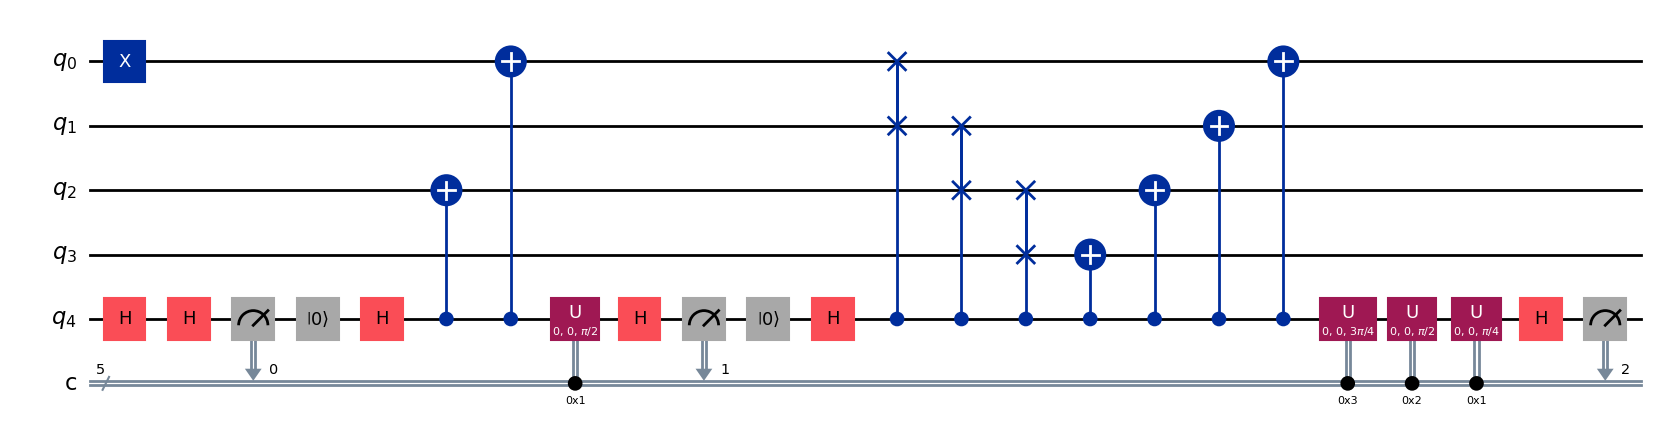

In [11]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

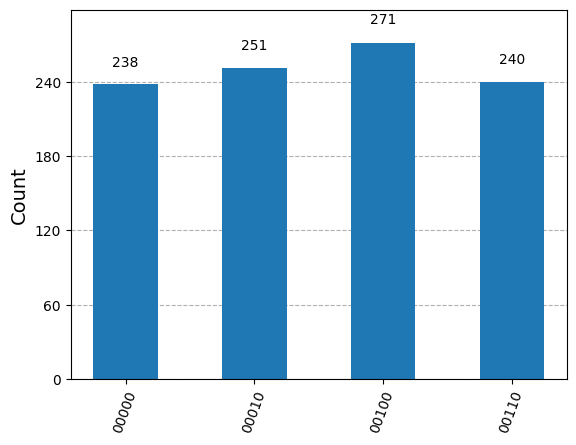

In [12]:
sim_job = sim.run([shor], shots=1000)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor)
plot_histogram(sim_data)

We see the measurements yield $x = 0, 2, 4$ and $6$ with equal(ish) probability. Using the continued fraction expansion for $x/2^3$, we note that only $x = 2$ and $6$ give the correct period $r = 4$, and thus the factors $p = \text{gcd}(a^{r/2}+1,15) = 3$ and $q = \text{gcd}(a^{r/2}-1,15) = 5$. 

Why don't you try seeing what you get for $a = 2, 8, 11, 13$?